## 1. Setup Development Environment

In [1]:
# !pip install -q git+https://github.com/huggingface/transformers.git
# # !pip install -q "transformers>=4.22.0" # comment in when version is released
# !pip install -q datasets sentencepiece tensorboard
# # install git-fls for pushing model and logs to the hugging face hub
# !sudo apt-get install git-lfs --yes


In [2]:
# from huggingface_hub import notebook_login

# notebook_login()


## 2. Load SROIE dataset

```bash
# clone repository
git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
# copy data
cp -r ICDAR-2019-SROIE/data ./
# clean up
rm -rf ICDAR-2019-SROIE
rm -rf data/box
```

In [3]:
""" 
{"file_name": "0001.png", "text": "This is a golden retriever playing with a ball"}
{"file_name": "0002.png", "text": "A german shepherd"}

"""

' \n{"file_name": "0001.png", "text": "This is a golden retriever playing with a ball"}\n{"file_name": "0002.png", "text": "A german shepherd"}\n\n'

In [4]:
%%bash
pip install -q git+https://github.com/huggingface/transformers.git
# !pip install -q "transformers>=4.22.0" # comment in when version is released
pip install -q datasets sentencepiece tensorboard
# install git-fls for pushing model and logs to the hugging face hub
# sudo apt-get install git-lfs --yes


In [5]:
%%bash
rm -rf data

In [6]:
%%bash
# clone repository
git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
# copy data
cp -r ICDAR-2019-SROIE/data ./
# clean up
rm -rf ICDAR-2019-SROIE
rm -rf data/box


Cloning into 'ICDAR-2019-SROIE'...
Updating files: 100% (1980/1980), done.


In [7]:
import os
import json
from pathlib import Path
import shutil

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list
metadata_list = []

# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)
    # create "text" column with json string
    text = json.dumps(data)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
      # delete json file

# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

# remove old meta data
shutil.rmtree(metadata_path)


In [8]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")

# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")


/data/miniconda3/envs/donut/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 626 examples [00:00, 9656.94 examples/s]

Dataset has 626 images
Dataset features are: dict_keys(['image', 'text'])


Random sample is 164
OCR text is {"company": "SUNFISH", "date": "05/01/2018", "address": "22 LRG PERUSAHAAN 4 KIMPAL INDS.PARK B.CAVES", "total": "28.70"}


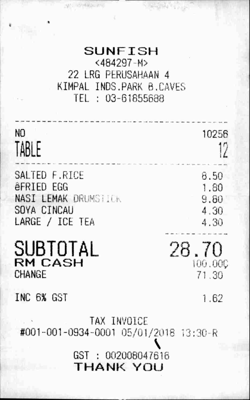

In [9]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))
#     OCR text is {"company": "LIM SENG THO HARDWARE TRADING", "date": "29/12/2017", "address": "NO 7, SIMPANG OFF BATU VILLAGE, JALAN IPOH BATU 5, 51200 KUALA LUMPUR MALAYSIA", "total": "6.00"}


## 3. Prepare dataset for Donut

#### metadata format

In [10]:
# Current JSON string
"""
{
  "company": "ADVANCO COMPANY",
  "date": "17/01/2018",
  "address": "NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR",
  "total": "7.00"
}
"""

# Donut document

"""
<s></s>
<s_company>ADVANCO COMPANY</s_company>
<s_date>17/01/2018</s_date>
<s_address>NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR</s_address>
<s_total>7.00</s_total>
</s>

"""


'\n<s></s>\n<s_company>ADVANCO COMPANY</s_company>\n<s_date>17/01/2018</s_date>\n<s_address>NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR</s_address>\n<s_total>7.00</s_total>\n</s>\n\n'

#### json2token

In [11]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")
#    Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
#    New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


Map: 100%|██████████| 626/626 [07:46<00:00,  1.34 examples/s]

Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


In [12]:
print(type(proc_dataset))

print(proc_dataset[1])

<class 'datasets.arrow_dataset.Dataset'>
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=439x1004 at 0x7F8158109240>, 'text': '<s><s_total>60.30</s_total><s_date>19/10/2018</s_date><s_company>INDAH GIFT & HOME DECO</s_company><s_address>27, JALAN DEDAP 13, TAMAN JOHOR JAYA, 81100 JOHOR BAHRU, JOHOR.</s_address></s>'}


In [13]:
"""
The next step is to tokenize our text and encode the images into tensors. 
Therefore we need to load DonutProcessor, 
add our new special tokens and adjust the size of the images when processing 
from [1920, 2560] to [720, 960] to need less memory and have faster training.
"""

'\nThe next step is to tokenize our text and encode the images into tensors. \nTherefore we need to load DonutProcessor, \nadd our new special tokens and adjust the size of the images when processing \nfrom [1920, 2560] to [720, 960] to need less memory and have faster training.\n'

In [14]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
/data/miniconda3/envs/donut/lib/python3.10/site-packages/transformers/models/donut/processing_donut.py:192: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [15]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}

    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])


Map: 100%|██████████| 626/626 [02:09<00:00,  4.85 examples/s]


In [16]:
# from datasets import load_from_disk
# from transformers import DonutProcessor

## COMMENT IN in case you want to save the processed dataset to disk in case of error later
# processed_dataset.save_to_disk("processed_dataset")
# processor.save_pretrained("processor")

## COMMENT IN in case you want to load the processed dataset from disk in case of error later
# processed_dataset = load_from_disk("processed_dataset")
# processor = DonutProcessor.from_pretrained("processor")



+ The last step is to split the dataset into train and validation sets.

In [17]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)


DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 563
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 63
    })
})


## 4. Fine-tune and evaluate Donut model

```bash
After we have processed our dataset, we can start training our model. Therefore we first need to load the naver-clova-ix/donut-base model with the VisionEncoderDecoderModel class. The donut-base includes only the pre-trained weights and was introduced in the paper OCR-free Document Understanding Transformer by Geewok et al. and first released in this repository.

In addition to loading our model, we are resizing the embedding layer to match newly added tokens and adjusting the image_size of our encoder to match our dataset. We are also adding tokens for inference later.
```

In [18]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)


New embedding size: Embedding(57533, 1024)


/data/miniconda3/envs/donut/lib/python3.10/site-packages/transformers/models/donut/processing_donut.py:192: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [20]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "donut-base-sroie"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=False,
    # hub_strategy="every_save",
    # hub_model_id=hf_repository_id,
    # hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)


TypeError: Accelerator.__init__() got an unexpected keyword argument 'use_seedable_sampler'